Adam Peetz<br>
September 18th 2022<br>
MSDS680 Week 4 Assignment<br>
Regis University<br>
Professor Nasheb Ismaily<br>

# Credit Risk Assessment with Decision Trees and Random Forest

Loaning money to a person who cannot repay has financial consequences for the lender. If it is done systemically, it can have larger repercussions for the economy, as occurred during the subprime mortgage crisis in 2008. Credit worthiness can be difficult for a bank employee to evaluate by instinct alone. Data science can help with this problem by using data to predict the credit worthiness of businesses and individuals applying for a loan. <br>

From the bank's perspective, it is 5 times costlier to loan money to someone who is not credit worthy than it is to deny a loan to someone who should have been eligible. This cost matrix will be used to guide the creation of a decision tree classifier that seeks to minimize miscategorization of "bad" creditors (category 2) using precision as a metric. <br> 

The dataset used in this notebook was prepared by Dr. Hans Hofmann(n.d) at The University of Hamburg.<br>


In [1]:
# import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pydotplus
import collections
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
#import dataset
credit_df = pd.read_csv('assign_wk4/german_credit_risk.csv', sep=',')

# Data Preparation

Data must be prepared before it is submitted for analysis to machine learning algorithms. Sampling the first 5 rows of the dataset displays a mix of categorical and numeric values of varying scale. There are no null values in the dataset. To prepare this data for classification, all categorical features will be assigned numeric labels using sci-kit learn's labelencoder. After text values have been transformed to numeric, features will be normalized/scaled using ski-kit learn's minmaxscaler. The label encoding and feature scaling operations are performed in the cells below.



In [3]:
#sample DF
credit_df.head()

,Checking.Account,Duration,Credit.Hist,Purpose,Credit.Amount,Saving.Account,Employmnet,Disposable.Income,Personal.Status,Other.Debtors,...,Property,Age,Other.Loans,Housing,Existing.Credits,Job,Number.Liable,Telephone,Foreign.Worker,Cost.Matrix
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
#Check for missing values
credit_df.isnull().sum()

Checking.Account     0
Duration             0
Credit.Hist          0
Purpose              0
Credit.Amount        0
Saving.Account       0
Employmnet           0
Disposable.Income    0
Personal.Status      0
Other.Debtors        0
Present.Residence    0
Property             0
Age                  0
Other.Loans          0
Housing              0
Existing.Credits     0
Job                  0
Number.Liable        0
Telephone            0
Foreign.Worker       0
Cost.Matrix          0
dtype: int64

In [5]:
#create label encoder object
labelencoder= LabelEncoder()

#define column names for encoding
encoder_names = ['Checking.Account','Credit.Hist','Purpose','Saving.Account','Employmnet','Personal.Status','Other.Debtors', \
               'Present.Residence', 'Property', 'Housing','Job', 'Telephone','Foreign.Worker','Other.Loans' ]

#apply encoding to dataframe
for col in encoder_names:
    credit_df[col] = labelencoder.fit_transform(credit_df[col])

In [6]:
#define scaler objext
scaler = MinMaxScaler()

#define column names for scaling
scaler_names = ['Checking.Account','Credit.Hist','Purpose','Saving.Account','Employmnet','Personal.Status','Other.Debtors', \
               'Present.Residence', 'Property', 'Housing','Job', 'Telephone','Foreign.Worker','Other.Loans' , 'Duration',\
               'Credit.Amount','Disposable.Income','Age','Existing.Credits','Number.Liable']

#apply scaling to dataframe
for col in scaler_names:
    credit_df[col] = scaler.fit_transform(credit_df[col].values.reshape(-1,1))

In [7]:
#sample transformed DF
credit_df.head()

,Checking.Account,Duration,Credit.Hist,Purpose,Credit.Amount,Saving.Account,Employmnet,Disposable.Income,Personal.Status,Other.Debtors,...,Property,Age,Other.Loans,Housing,Existing.Credits,Job,Number.Liable,Telephone,Foreign.Worker,Cost.Matrix
0,0.000000,0.029412,1.00,0.444444,0.050567,1.0,1.00,1.000000,0.666667,0.0,...,0.000000,0.857143,1.0,0.5,0.333333,0.666667,0.0,1.0,0.0,1
1,0.333333,0.647059,0.50,0.444444,0.313690,0.0,0.50,0.333333,0.333333,0.0,...,0.000000,0.053571,1.0,0.5,0.000000,0.666667,0.0,0.0,0.0,2
2,1.000000,0.117647,1.00,0.777778,0.101574,0.0,0.75,0.333333,0.666667,0.0,...,0.000000,0.535714,1.0,0.5,0.000000,0.333333,1.0,0.0,0.0,1
3,0.000000,0.558824,0.50,0.333333,0.419941,0.0,0.75,0.333333,0.666667,1.0,...,0.333333,0.464286,1.0,1.0,0.000000,0.666667,1.0,0.0,0.0,1
4,0.000000,0.294118,0.75,0.000000,0.254209,0.0,0.50,0.666667,0.666667,0.0,...,1.000000,0.607143,1.0,1.0,0.333333,0.666667,1.0,0.0,0.0,2


In [8]:
#divide into features and targets
features = credit_df.drop('Cost.Matrix', axis=1)
targets = credit_df['Cost.Matrix']

#break data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2,random_state=1)

# Exploratory Data Analysis

Three types of exploratory data analysis will be performed to show some basic information about the dataset: a risk class distribution, a PCA scatterplot, and a correlation heatmap. <br>

## Risk Class Distribution

The risk class distribution is plotted in the bar chart below. It shows that 700 of 300 rows are category 1 "good" rows. This information can be used to generate a null accuracy rate of 70%, which could be used to compare the accuracy of future models. <br>



<Figure size 432x288 with 0 Axes>

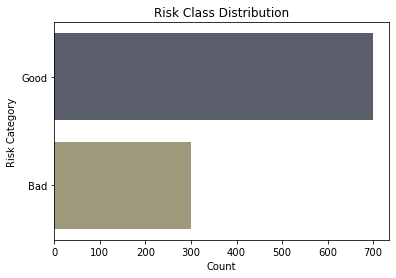

<Figure size 432x288 with 0 Axes>

In [9]:
#group and count, sort for highest value
graph = credit_df.groupby('Cost.Matrix').count()
graph['Cost.Matrix'] = ['Good', 'Bad']
graph.sort_values(by='Duration',inplace=True,ascending=False)
sns.barplot(data=graph,x='Duration',y='Cost.Matrix',palette='cividis')
plt.ylabel('Risk Category')
plt.xlabel('Count')
plt.title('Risk Class Distribution')

plt.figure()

## PCA Projection of Values

The PCA projection of the data shows that the two classes are intermingled, but there is a higher concentration of category 2 datapoints towards the bottom of the graph. The algorithm may have a difficult time creating a decision boundary that allows it to predict for category 2 datapoints that are far away from this cluster at the top of the graph. <br>


Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

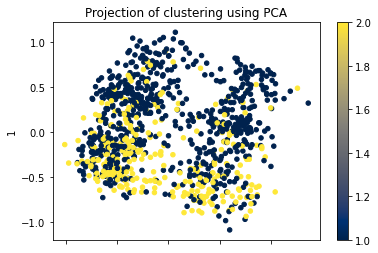

In [10]:
#create PCA object
pca = PCA()
#reduce dimensonality of the features
data_reduced = pca.fit_transform(features)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=targets, cmap='cividis')
plt.title('Projection of clustering using PCA')

## Correlation Heatmap

The correlation heatmap shows that many of the features lack correlation to the prediction variable. These may be candidates for removal from the dataset, however, they will be left in the dataset to demonstrate the effect pruning has on feature importance in the tree. <br>


<AxesSubplot:>

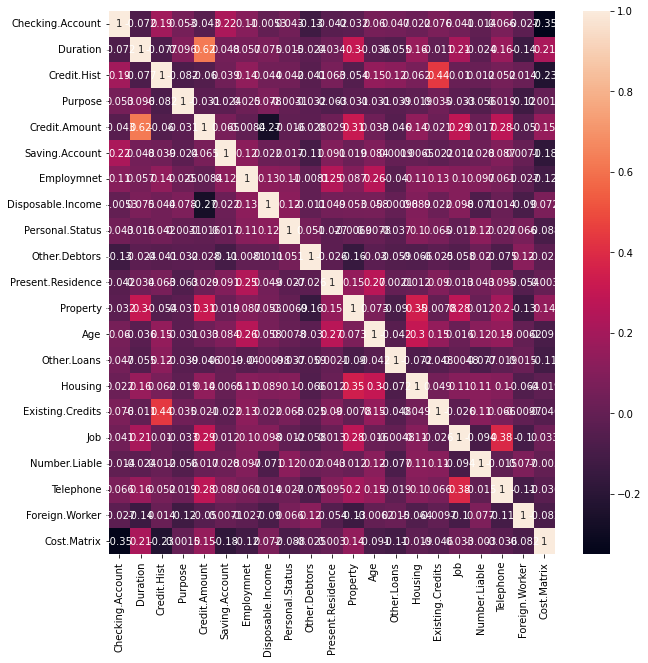

In [11]:
#plot a correlation heatmap
f = plt.figure(figsize=(10, 10))
sns.heatmap(credit_df.corr(), annot=True)

# Baseline with Naive Bayes

A Naive Bayes (NB) model will be created to establish a baseline for comparison of the upcoming decision tree models. Naive Bayes is commonly used as a baseline model for comparison of other algorithms as it uses simple probability calculations to predict for each feature and is fast to compute.


In [12]:
#define, fit, and score 

#create model, fit model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

#generate accuracy on training
mnbpreds = mnb.predict(X_train)
print('Accuracy on training was:')
print(accuracy_score(y_train,mnbpreds))

#generate test preditions
testpreds = mnb.predict(X_test)
print('Accuracy on test was:')
print(accuracy_score(y_test,testpreds))
print('Precision on test was:')
print(precision_score(y_test,testpreds))

Accuracy on training was:
0.7075
Accuracy on test was:
0.72
Precision on test was:
0.7157360406091371


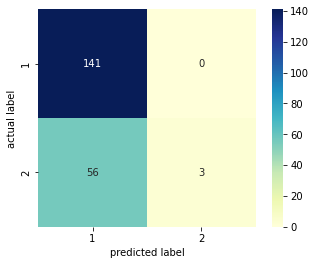

In [13]:
# Plot Confusion Matrix

cm = confusion_matrix(y_test,testpreds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Baseline NB Discussion

The baseline NB model has a raw accuracy score of 72%. This accuracy comes from predicting that nearly everything is class 1. The confusion matrix shows that the Naive Bayes model is unlikely to predict for class 2 on the current dataset. Its accuracy score of 72% only beats the null accuracy rate of 70% by 2%. <br>

Baseline accuracy on training was: 70%<br>
Baseline accuracy on test was: 72%<br>
Baseline precision on test was: 71%<br>

Using the values in the metadata's cost matrix, a cost of 280 can be assigned to the false predictions made by the NB model.



# Predicting with a Decision Tree

Decision trees use branching chains of logic to separate features into successively smaller portions that eventually terminate on a prediction node. Decision trees generate accurate predictions that will fit perfectly to training data if they are allowed to grow unchecked. This method of prediction works for both classification and regression problems. Decision trees are transparent models. Unlike other "black box" learning methods, the logic behind a decision tree's prediction will always be explainable by tracing the logic in a branch it used to arrive there. A single decision tree will be grown to predict for category 1 and 2 in the credit dataset to attempt to improve upon the performance of the NB baseline model.


In [14]:
# define, fit, and score 

# define the initial model
untrimmed_model = tree.DecisionTreeClassifier(random_state=125)
untrimmed_model.fit(X_train, y_train)

#Generate Accuracy on Training
trainpreds = untrimmed_model.predict(X_train)
print('Accuracy on training was:')
print(accuracy_score(y_train,trainpreds))

#Generate Accuracy on Test and Precision on Test
testpreds = untrimmed_model.predict(X_test)
print('Accuracy on test was:')
print(accuracy_score(y_test,testpreds))
print('Precision on test was:')
print(precision_score(y_test,testpreds))

Accuracy on training was:
1.0
Accuracy on test was:
0.7
Precision on test was:
0.7793103448275862


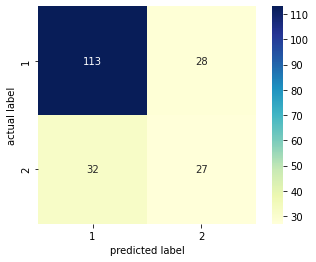

In [15]:
# plot confusion matrix
cm = confusion_matrix(y_test, testpreds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Accuracy Discussion

The accuracy on training was 100%, this decision tree has overfit to its training data. The decision trees accuracy on test was 70%, a 2% decrease from the NB baseline model. However, this model does show increased precision, outperforming the NB model by 6%.<br>

Decision tree accuracy on training was: 100%<br>
Decision tree accuracy on test was: 70%, 2% worse than the NB baseline. <br>
<b>Decision tree precision on test was: 77%, an increase of 6% over the baseline. </b><br>


## Confusion Matrix

The confusion matrix shows that the model has begun to predict for class 2 individuals. When evaluating cost as defined by the bank, the NB model had a miscategorization cost of 280, compared to a miscategorization cost of 188 in this decision tree model, a 92 point improvement.


# Feature Importance and Tree Visualization

The decision tree model has an attribute.feature_importances__ that will extract the weighted impurity score for each feature in the model. The .feature_importances__ attribute shows that 'Checking.Account', 'Employment', and 'Credit History', were the most important features to this model.<br>

The tree visualization shows a massive incomprehensible decision tree. It is pretty to look at but has an enormous number of branches and is extremely deep. This decision tree was allowed to grow endlessly and eventually fit perfectly to its training data. <br>


In [16]:
#extract importance list
importance_list = list(zip(scaler_names,untrimmed_model.feature_importances_))
sorted_import_feature = sorted(importance_list, key = lambda x: x[1],reverse=True)
sorted_import_feature

[('Checking.Account', 0.14811956778900087),
 ('Employmnet', 0.1348094383783426),
 ('Credit.Hist', 0.10579590447380938),
 ('Foreign.Worker', 0.07103246048531875),
 ('Property', 0.06882079779173207),
 ('Other.Debtors', 0.05744186521021707),
 ('Purpose', 0.054382665340696405),
 ('Saving.Account', 0.04889873710517175),
 ('Present.Residence', 0.04885044429622678),
 ('Disposable.Income', 0.04165363017961078),
 ('Personal.Status', 0.0390684596626364),
 ('Existing.Credits', 0.03487239384180425),
 ('Job', 0.03172487796037555),
 ('Duration', 0.029625450835525143),
 ('Housing', 0.02584306732897131),
 ('Telephone', 0.024081165063506087),
 ('Other.Loans', 0.01688824368503654),
 ('Credit.Amount', 0.008396954999971382),
 ('Age', 0.005481495100628258),
 ('Number.Liable', 0.004212380471418754)]

In [17]:
#create decision tree visualization
dot_data = tree.export_graphviz(untrimmed_model,
                                feature_names=scaler_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('images_wk4/untrimmeddecisiontree.png')

True

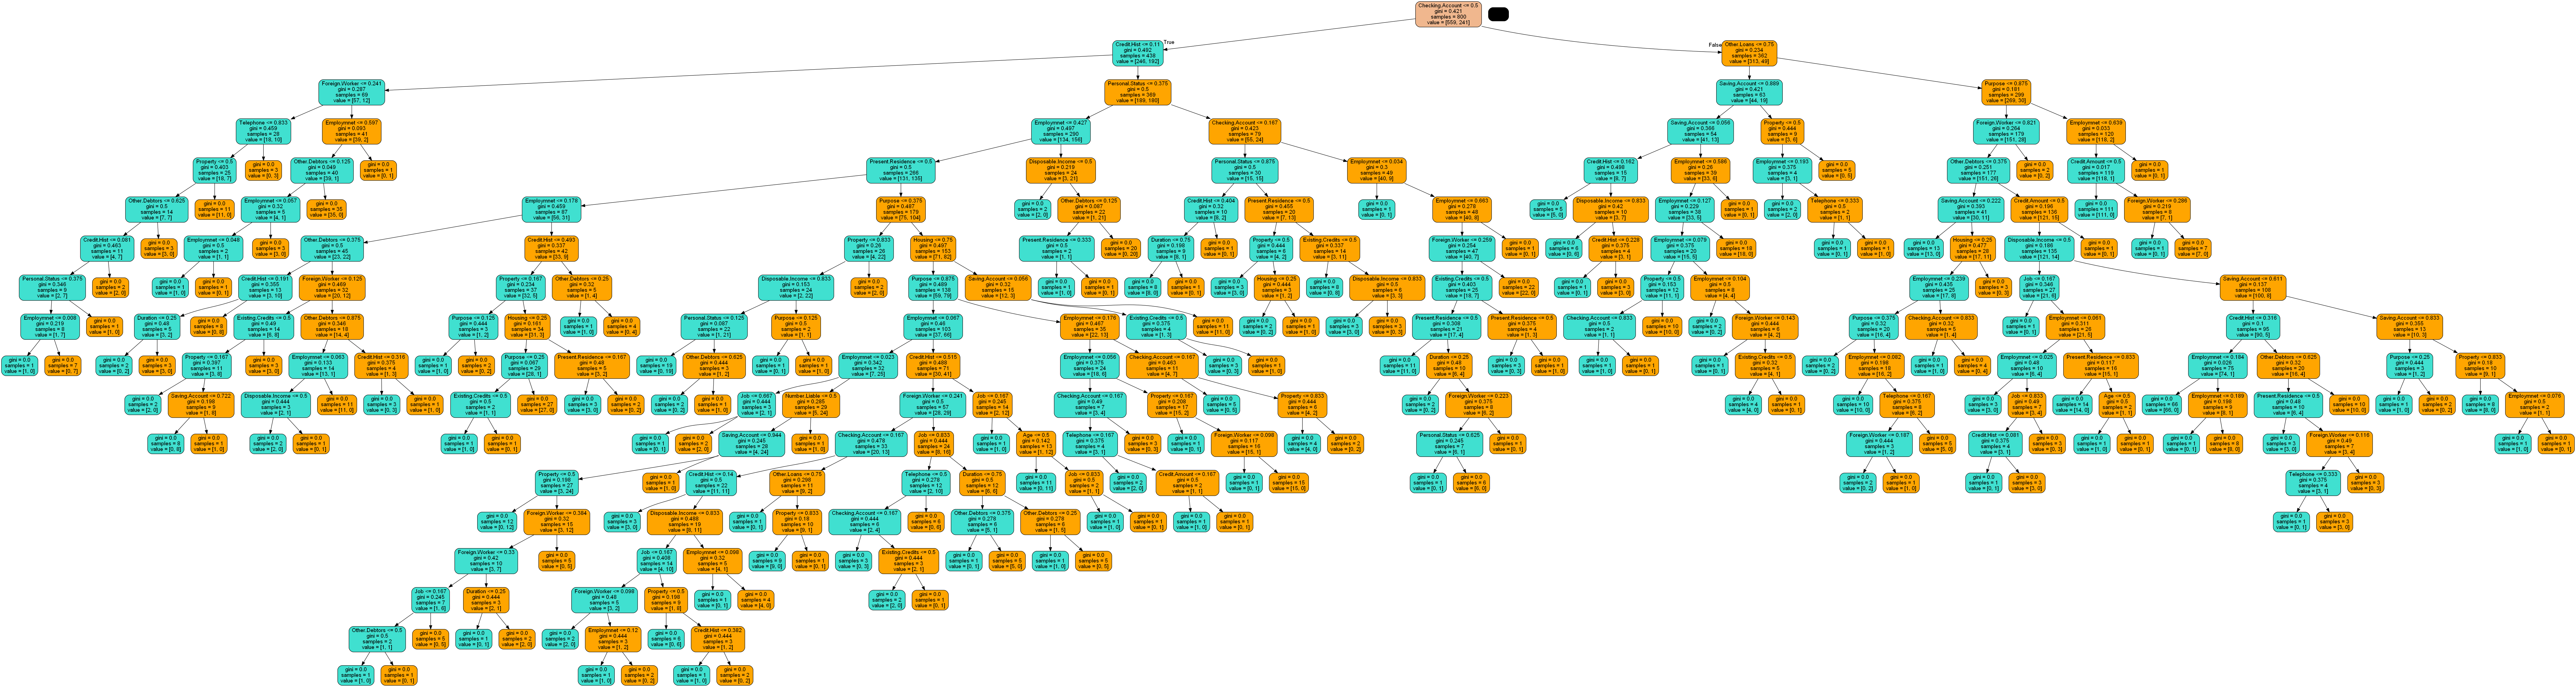

In [18]:
#display the png here
Image(filename='images_wk4/untrimmeddecisiontree.png') 

# Pruning a Decision Tree

## The Problem with Overfitting

Models that are overfit to their training data do not generalize well to unseen data sets. A balance needs to be struck between a model's fit to the training data and its accuracy on test. A model that will generalize well to unseen data will have approximately the same accuracy on training predictions as it has on test.

## Cost Complexity Pruning

The decision tree classifier in sci-kit learn includes a method and hyperparameter to facilitate pruning using cost complexity. Cost complexity pruning recursively finds the node with the “weakest link” which is characterized by the parameter ccp_alpha. The ccp_alpha hyperparameter can be set to control the number of nodes that are pruned from the tree, starting with those that have the least effect on the outcome of the model. Greater values of ccp_alpha increase the number of nodes pruned.

This method was adapted from the sci-kit learn tutorial and a web resource posted by Arun Mohan (2021).

1. First, the cost complexity pruning path method is called which extracts meaningful ccp_alpha values from the model.
2. Then, a list of models is created using the various ccp_alpha values extracted by the pruning path method.
3. Finally, those models are iterated through and scored with performance mapped on a line chart that displays accuracy vs alpha for training and test sets.

The ccp_alpha number can be chosen based on the training and test curves displayed on the accuracy vs alpha graph. The cost complexity pruning method recommends a ccp_alpha number of about 0.005 for this dataset. The ccp_alpha method, model, and metrics are shown in the cells below.



In [19]:
#extract cost complexity pruning paths from model
path = untrimmed_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [20]:
#generate library of classifier models to iterate through
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.04548932561681679


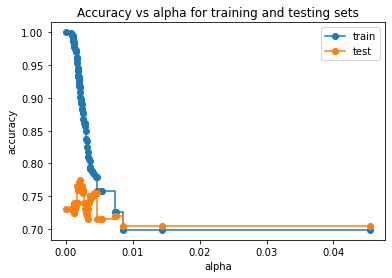

In [21]:
# generate graph of model scores and ccp_alphas values
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [22]:
#define, fit, and score

# Define model and fit
prunedmodel = tree.DecisionTreeClassifier(random_state=125, ccp_alpha=0.005)
prunedmodel.fit(X_train, y_train)

#Generate Accuracy on Training
trainpreds = prunedmodel.predict(X_train)
print('Accuracy on training was:')
print(accuracy_score(y_train,trainpreds))

#Generate Accuracy on Test
testpreds = prunedmodel.predict(X_test)
print('Accuracy on test was:')
print(accuracy_score(y_test,testpreds))
print('Precision on test was:')
print(precision_score(y_test,testpreds))

Accuracy on training was:
0.7575
Accuracy on test was:
0.715
Precision on test was:
0.7837837837837838


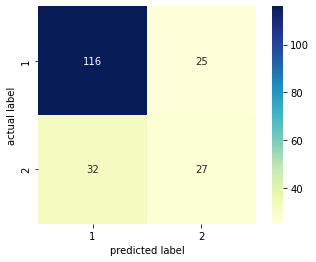

In [23]:
#Create confusion matrix
cm = confusion_matrix(y_test, testpreds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Accuracy Discussion

An improvement was seen in the gap between training and test sets. Pruning the model has solved the problem of overfitting to the training data. The pruned model should generalize better to unseen data. The raw accuracy was also boosted 1% from the original model, however the precision remains about the same. This means that the model is not doing a better job of discriminating between "bad" labels which is the label the bank prefers to improve accuracy on.<br>

Pruned tree accuracy on training was 75% <br>
Pruned tree accuracy on test was 71% <br>
<b>Pruned precision on test was 78%. (A 0.004% improvement over the untrimmed model)</b>

## Confusion Matrix

The confusion matrix illustrates the story told by the precision scores. Pruning did not create an improvement to the prediction of "bad" credit. 32 bad are predicted as good, the same outcome as the unpruned model. The miscategorization cost of this model is 185, a 3 point improvement over the untrimmed model.

# Feature Importance and Tree Visualization

A display of feature importance shows that 'Saving.Account','Other.Debtors','Property','Housing', 'Job','Telephone','Foreign.Worker', 'Duration','Credit.Amount','Disposable.Income','Age','Existing.Credits', and 'Number.Liable' were low importance features that were pruned from the model. This is indicated by the assigned feature importance score of 0. <br>

The visualization of the decision tree displays the effects of pruning. Compared to the original tree, which was a behemoth, the pruned tree is manageable in size.


In [24]:
#generate feature importances
importance_list = list(zip(scaler_names,prunedmodel.feature_importances_))
sorted_import_feature = sorted(importance_list, key = lambda x: x[1],reverse=True)
sorted_import_feature

[('Checking.Account', 0.48520508552563546),
 ('Credit.Hist', 0.15272749809562491),
 ('Personal.Status', 0.09075737734479822),
 ('Employmnet', 0.07927221507644432),
 ('Present.Residence', 0.07881154096131833),
 ('Purpose', 0.057025403116108646),
 ('Other.Loans', 0.056200879880070206),
 ('Saving.Account', 0.0),
 ('Other.Debtors', 0.0),
 ('Property', 0.0),
 ('Housing', 0.0),
 ('Job', 0.0),
 ('Telephone', 0.0),
 ('Foreign.Worker', 0.0),
 ('Duration', 0.0),
 ('Credit.Amount', 0.0),
 ('Disposable.Income', 0.0),
 ('Age', 0.0),
 ('Existing.Credits', 0.0),
 ('Number.Liable', 0.0)]

In [25]:
#generate decision tree graph
dot_data = tree.export_graphviz(prunedmodel,
                                feature_names=scaler_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('images_wk4/pruneddecisiontree.png')

True

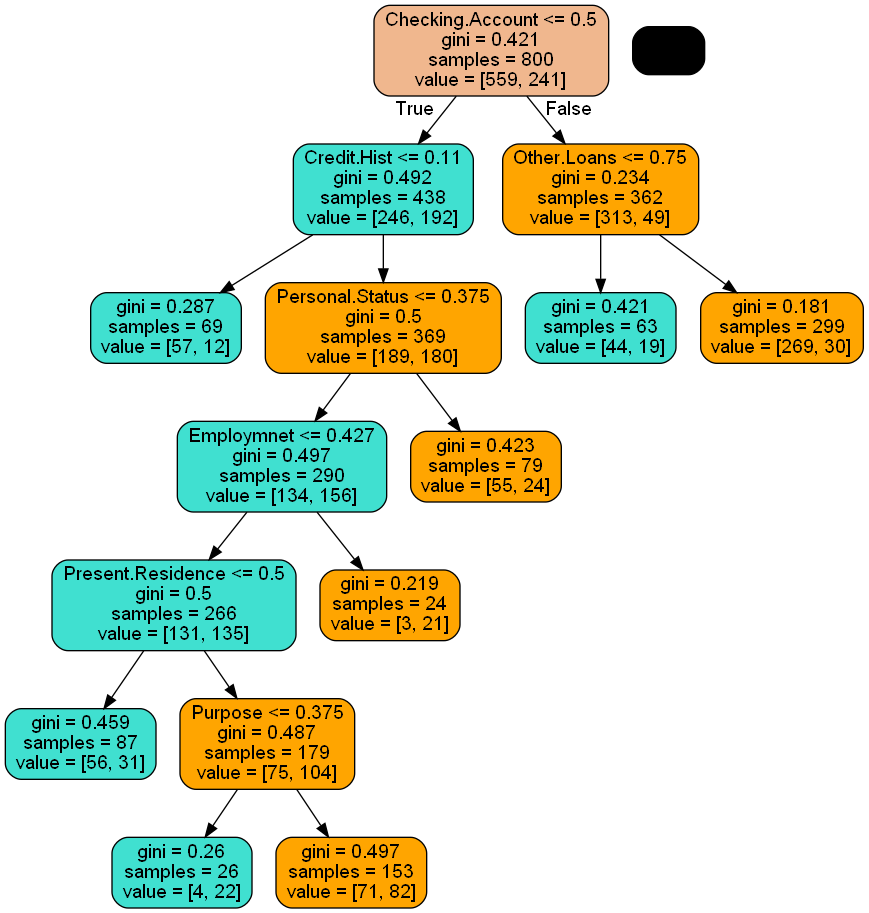

In [26]:
#display the png here
Image(filename='images_wk4/pruneddecisiontree.png') 

# Random Forest

A random forest model is an ensemble learning method that seeks to improve upon the predictions made by a single decision tree with a collection of trees that vote together on an outcome. When the predictions of many decision trees are averaged together, the outcome tends to be more accurate than the prediction made by a single tree alone. A random forest classification model will be created to attempt to improve on the precision of previous models. <br>

## Hyperparameter Optimization with GridSearchCV

There are many combinations of hyperparameters that can be used to construct a random forest model. It is unlikely that the default parameters of the model offer the best performance for the tree. To obtain the optimum combination of parameters a GridSearch can be performed to brute-force check a combination of hyperparameters and return the set that offered the best performance for the model. The random forest model will be tuned with GridSearchCV in the code below.


In [27]:
## optimize alpha for MNB
## this iterates though many models and will take a bit of time to run

#define parameters to search
params = {'max_depth': (3,4,5,6,7,8,9,10,11,12,13,14,15,16),
          'n_estimators': (50,100,150,200),
          'max_features': (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20),
         }

#create grid search model object
opt = GridSearchCV(RandomForestClassifier(n_jobs = -1, random_state=125),params,scoring='precision')

#fit gridsearch to training data
opt.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=125),
             param_grid={'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16),
                         'max_features': (3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15, 16, 17, 18, 19, 20),
                         'n_estimators': (50, 100, 150, 200)},
             scoring='precision')

In [28]:
## display best hyperparameters
opt.best_estimator_

RandomForestClassifier(max_depth=15, max_features=8, n_jobs=-1,
                       random_state=125)

In [29]:
#define fit and test

#define 
forest_model = RandomForestClassifier(max_depth=15, max_features=8, n_jobs=-1,
                       random_state=125)

#fit
forest_model.fit(X_train,y_train)

#generate scores for training
forest_preds = forest_model.predict(X_train)
print('Accuracy on training was:')
print(accuracy_score(y_train,forest_preds))

#generate scores for test
testpreds = forest_model.predict(X_test)
print('Accuracy on test was:')
print(accuracy_score(y_test,testpreds))
print('Precision on test was:')
print(precision_score(y_test,testpreds))

Accuracy on training was:
1.0
Accuracy on test was:
0.775
Precision on test was:
0.8037974683544303


# Random Forest Accuracy Discussion

The random forest model had very high accuracy on its training data and a comparatively low score on its test. This division in training and test scores suggests the model is overfit to its training data. It did show a small improvement to its precision, which indicates that the model is more effective at discriminating against category 2 labels than previous models. <br>

Random forest accuracy on training was 100%<br>
Random forest accuracy on test was 77%<br>
<b>Random Forest precision on test was 80%. A 2% improvement over the pruned tree.</b>


## Confusion Matrix

The confusion matrix shows the improvement that was made by the random forest model. For predictions of "bad" credit, only 31 are miscategorized as good. <br>

The miscategorization cost of this model is 169, a 16 point improvement over the pruned model, the lowest mis categorization cost of any model so far.<br>


# Feature Importance

The list of feature importance’s for the random forest model are similar to the list that was generated for previous models. 'Employment', 'Checking.Account', 'Credit.Hist', and 'Foreign.Worker" were important features to the random forest and to previous models. <br>


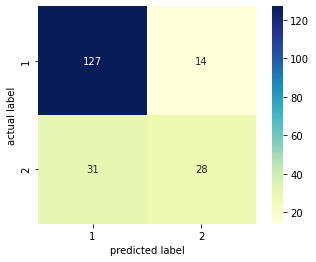

In [30]:
# Generate confusion matrix
cm = confusion_matrix(y_test, testpreds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

In [31]:
# generate feature importance
importance_list = list(zip(scaler_names,forest_model.feature_importances_))
sorted_import_feature = sorted(importance_list, key = lambda x: x[1],reverse=True)
sorted_import_feature

[('Employmnet', 0.15137753691433078),
 ('Checking.Account', 0.11912554989879173),
 ('Foreign.Worker', 0.10779763738343433),
 ('Credit.Hist', 0.09910785293171726),
 ('Saving.Account', 0.06755835380387025),
 ('Purpose', 0.06080475137288822),
 ('Other.Debtors', 0.046750790511741094),
 ('Personal.Status', 0.044889714995721995),
 ('Present.Residence', 0.04425125433461973),
 ('Job', 0.03918047152050311),
 ('Telephone', 0.03678935365241115),
 ('Property', 0.030559348880363178),
 ('Disposable.Income', 0.0304633897226472),
 ('Other.Loans', 0.025751086110309566),
 ('Duration', 0.02162791682598537),
 ('Housing', 0.0207568146495762),
 ('Existing.Credits', 0.019122660047544645),
 ('Credit.Amount', 0.01661468720247385),
 ('Age', 0.013765656656782964),
 ('Number.Liable', 0.0037051725842874956)]

# Summary

Each adaptation made to the model improved its precision on test data and its cost as judged by the bank's cost matrix. The random forest classifier achieved the best precision and lowest cost of the set, scoring 169 points with 80% precision. A drawback to implementing the random forest classifier is that it is overfit to its training data. The best model for general prediction is most likely the pruned tree model. While this model has a higher cost, the spread between scores on training and test sets suggests that it is better generalized to its task than other models. This would help it perform consistently when shown data outside of its training and test sets. <br>

## Model Recommendation: Pruned Tree 

The confusion matrices show that the improvement on cost score in the random forest model comes from accurate predictions of category 1 "good". Only 1 additional classification of 2 "bad" was achieved by the random forest model. The training scores of the random forest model suggest it is overfit to its data and would not generalize well when shown unseen data points. Since most of the cost improvements came from predictions of category 1, rather than the preferred category 2, and the model displays traits of being overfit, it is recommended the bank use a single pruned decision tree to make its credit predictions for customers over a random forest model. <br>

## Final Cost Matrix Scores:

NB Baseline Cost: 280<br>
Untrimmed Tree Cost: 188<br>
Pruned Tree Cost: 185<br>
Random Forest Cost: 169<br>



# References

This notebook was created using a blend of techniques from Regis's MSDS600, MSDS680, and MSDS650 coursework. In addition to this, the reference literature for sci-kit learn, pandas, and seaborn was consulted to construct the code.

Hofmann, Hans. (n.d.). <i> German Credit Data</i> Institut f"ur Statistik und "Okonometrie Universit"at Hamburg  

Mohan, Arun. (2021). <i> Pruning Decision Trees. kaggel.com. Retrieved 9/9/2022 from https://www.kaggle.com/code/arunmohan003/pruning-decision-trees-tutorial

Pandas Development Team. 2021. <i>Python API reference</i> from pandas.pydata.org https://pandas.pydata.org/docs/reference/index.html

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. <i> Journal of Machine Learning Research 12,</i> 2825-2830

Waskom ML (2021). seaborn: statistical data visualization. <i> Journal of Open Source Software 6</i>(60): 3021.a